In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, BatchNormalization, Activation, Input, Add, Concatenate,\
                         Bidirectional, SimpleRNN, LSTM, GRU
from keras_layer_normalization import LayerNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add, MaxPooling1D,LSTM
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

Using TensorFlow backend.


In [2]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, 
    
type|: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [3]:
df = pd.read_csv("Quoraquestions.csv")
#answer_count_list = non_anonymous_answer_count+anonymous_answer_count
labels = []

for i in range(df.shape[0]):   
    if(df["anonymous_answer_count"][i] > 0):
        labels.append(1)
        
    else:
        labels.append(0)
Counter(labels)
#Construct the labels of questions: 1 means receiving anonymous answers, 0 means not.
xtrain = df["question_title_list"]

In [8]:
train_texts = xtrain
#print(train_texts[0])
train_tokens = [tokenize(text) for text in train_texts]
#print(train_tokens[0])
tokens = []
for text in train_tokens:
    text2 = [i.lower() for i in text]
    text1 = []
    for i in text2:
        if(i != "?"):
            text1.append(i)
    tokens.append(text1)
train_tokens = tokens
#print(train_tokens[0])
filtered_sentence = [filter_stopwords(text) for text in train_tokens]
#print(filtered_sentence[0])
#print(len(train_tokens))
train_stemmed = [stem(tokens) for tokens in filtered_sentence]
#print(train_stemmed[0])
#print(len(train_stemmed))
train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
#print(train_2_gram[0])
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
#print(train_3_gram[0])
train_feats = list()
for i in range(len(train_texts)):
    train_feats.append(
        train_stemmed[i])


In [6]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector


In [12]:
max_len = 50
min_freq=3
# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)
# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])



Size of features: 3690


In [13]:
Counter(labels)

Counter({0: 10028, 1: 1099})

In [14]:
from imblearn.over_sampling import SMOTE, ADASYN

#Using smote to solve the unbalanced data problems
X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(train_feats_matrix,labels)
print(len(y_resampled_smote))
Counter(y_resampled_smote)
x_train = X_resampled_smote
y_train = y_resampled_smote
data_num= x_train.shape[0]
index = np.arange(data_num)  # 生成下标  
np.random.shuffle(index)
print(index)
x_train = x_train[index]
y_train = y_train[index]

20056
[12797  2143  3036 ... 13098 13604  9003]


In [15]:
Counter(y_train)

Counter({1: 10028, 0: 10028})

In [16]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, random_state=0)


/Users/macbook/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
x_train.shape

(15042, 50)

In [26]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="binary_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="sigmoid",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [27]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=1,
                  rnn_type="lstm", num_rnn_layers=2, num_mlp_layers=3,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.2)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
lstm_history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=15, batch_size=64, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(x_train, y_train,
                             batch_size=64)
test_score = model.evaluate(x_test, y_test,
                            batch_size=64)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

/Users/macbook/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/macbook/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


5014/5014 [==============================] - 5s 988us/step
training loss: 0.7096998958079807 training accuracy 0.5805079340934753
test loss: 0.7130370868788234 test accuracy 0.5735939145088196


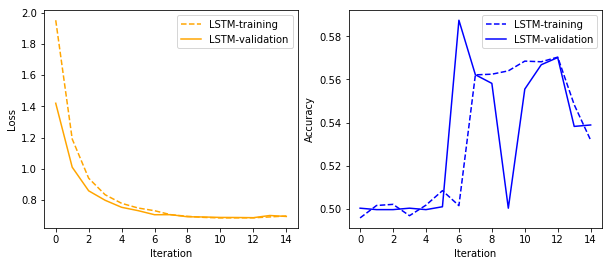

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()